In [2]:

import requests

import matplotlib.pyplot as plt
import seaborn as sns

import umap, numpy as np, pandas as pd


2025-07-03 10:50:08.372995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 10:50:08.382935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751532608.395357   54338 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751532608.398911   54338 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751532608.407835   54338 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Or for specific warning types:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [7]:
labyrinthus_df = pd.read_parquet("../data/labyrinthus_df_classified.parquet")
labyrinthus_df = labyrinthus_df[['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'classification', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end']]
labyrinthus_df.sample(5)


,author,title,grela_id,sentence_id,sentence_text,context_3sents,tokens,concordance_tokens,classification,not_before,not_after,date_random,lagt_genre,lagt_provenience,noscemus_genre,noscemus_discipline,target_token_id,target_char_start,target_char_end
236,Rabanus Maurus,De universo,cc_8922,cc_8922_7323,qualem bestiam dicunt fabulose in Labyrintho i...,Porro Minocentaurum nomen sumpsisse ex tauro e...,"[{'char_end': 6, 'char_start': 0, 'lemma': 'qu...","[{'char_end': 38, 'char_start': 36, 'lemma': '...",mythological-architectural,780.0,856.0,812.0,None,None,None,None,373769804,34,44
272,"Paracelsus, Theophrastus von Hohenheim",None,emlap_100023,emlap_100023_43,"Quidam uero ingrediuntur labyrinthum, & eo usq...","Nam ibi quaerunt, ubi nihil est, palpant, quod...","[{'char_end': 6, 'char_start': 0, 'lemma': 'qu...","[{'char_end': 59, 'char_start': 58, 'lemma': '...",mythological-architectural,1553.0,1553.0,1553.0,None,None,None,None,2540727,25,36
481,"Monte, Giovanni Battista da,Lublina, Walenty z",Ioannis Baptistae Montani Veronensis In nonum ...,noscemus_701795,noscemus_701795_163,"Quod cum ita sit, non potui facere Candide lec...",S. D. St animi bene constituti laetari bonis r...,"[{'char_end': 4, 'char_start': 0, 'lemma': 'qu...","[{'char_end': 244, 'char_start': 241, 'lemma':...",metaphorical-poetic,1554.0,1554.0,1554.0,None,None,"Commentary, Other (see description), Oration",Medicine,60738857,289,299
359,"Fuchs, Leonhart","Paradoxorum medicinae libri III, in quibus san...",noscemus_608631,noscemus_608631_108,"Hinc enim numerosa & immensa, quae ne per omne...","Quid, deum immortalem, tantam lurisprudentiae ...","[{'char_end': 4, 'char_start': 0, 'lemma': 'hi...","[{'char_end': 47, 'char_start': 42, 'lemma': '...",metaphorical-error,1535.0,1535.0,1535.0,None,None,"Monograph, Other (see description)",Medicine,127138969,114,125
789,"Guarinonius, Hippolytus",Chylosophiae academicae artis Aesculapiae novi...,noscemus_819057,noscemus_819057_1794,"quod magni, prudentesque ab omni saeculo Uiri,...","non obstante: | quod magni, prudentesque ab om...","[{'char_end': 4, 'char_start': 0, 'lemma': 'qu...","[{'char_end': 45, 'char_start': 41, 'lemma': '...",mythological-architectural,1648.0,1648.0,1648.0,None,None,Dialogue,Medicine,128282249,94,105


In [8]:
len(labyrinthus_df)

916

In [9]:
top_20_labels = labyrinthus_df['classification'].value_counts().head(20).index.tolist()
top_20_labels

['mythological-architectural',
 'medical-anatomical',
 'metaphorical-error',
 'metaphorical-poetic',
 'scientific-anatomical',
 'scientific-astronomical',
 'metaphorical-spiritual',
 'scientific-natural',
 'architectural-architectural',
 'medical-error',
 'scientific-architectural',
 'poetic-architectural',
 'scientific-alchemical',
 'religious-spiritual',
 'metaphorical-architectural',
 'architectural',
 'architectural-natural',
 'metaphorical-alchemical',
 'alchemical-anatomical',
 'architectural-anatomical']

In [147]:

# -------------------- 0. imports & model ----------------------------
import torch, numpy as np
from transformers import AutoTokenizer, AutoModel

MODEL_ID = "xlm-roberta-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModel.from_pretrained(MODEL_ID).to(DEVICE).eval()

# -------------------- 1. parameters -------------------
TARGET_LEMMA = "labyrinthus"
OPEN_POS = {"NOUN", "PROPN", "ADJ", "VERB"}


# -------------------- 2. helpers -----------------------
def build_sentence(tokens,
                   *,
                   anchor_use_lemma: bool,
                   context_use_lemma: bool,
                   pos_set=None) -> str:
    """
    Build a sentence string where the ANCHOR token can be forced to lemma
    while the context can be lemma or surface independently.
    """
    words = []
    for t in tokens:
        if pos_set is not None and t["pos"] not in pos_set:
            continue
        if t["lemma"].lower() == TARGET_LEMMA:
            words.append(t["lemma" if anchor_use_lemma else "token_text"].lower())
        else:
            words.append(t["lemma" if context_use_lemma else "token_text"].lower())
    return " ".join(words)


def find_sublist(haystack, needle):
    return [i for i in range(len(haystack) - len(needle) + 1)
            if haystack[i:i + len(needle)] == needle]


def embed_sentence_get_target(sentence: str, target_piece_ids):
    enc = tokenizer(sentence, return_tensors="pt",
                    add_special_tokens=True).to(DEVICE)
    hidden = model(**enc).last_hidden_state.squeeze(0)  # [seq_len, 768]

    starts = find_sublist(enc["input_ids"][0].tolist(), target_piece_ids)
    if not starts:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    k = len(target_piece_ids)
    vecs = [hidden[st:st + k].mean(dim=0) for st in starts]
    return torch.stack(vecs).mean(dim=0).cpu().detach().numpy()


# -------------------- 3. master extractor ---------------------------
def extract_embedding(tokens,
                      *,
                      anchor_use_lemma: bool,
                      context_use_lemma: bool,
                      pos_set=OPEN_POS):
    anchor = next(t for t in tokens if t["lemma"].lower() == TARGET_LEMMA)
    anchor_text = (anchor["lemma"] if anchor_use_lemma else anchor["token_text"]).lower()
    anchor_piece_ids = tokenizer(anchor_text, add_special_tokens=False)["input_ids"]

    sentence = build_sentence(tokens,
                              anchor_use_lemma=anchor_use_lemma,
                              context_use_lemma=context_use_lemma,
                              pos_set=pos_set)

    return embed_sentence_get_target(sentence, anchor_piece_ids)


# -------------------- 4. apply to DF ------------------
# 4a lemma / lemma context
labyrinthus_df["embed_lemma_openpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks, anchor_use_lemma=True, context_use_lemma=True))
)

# 4b surface / surface context (open POS)
labyrinthus_df["embed_surface_openpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks, anchor_use_lemma=False, context_use_lemma=False))
)

# 4c surface / surface context (all POS)
labyrinthus_df["embed_surface_allpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks, anchor_use_lemma=False, context_use_lemma=False,
        pos_set=None))
)

# 4d HYBRID  (lemma anchor, surface context)
labyrinthus_df["embed_hybrid_openpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks, anchor_use_lemma=True, context_use_lemma=False))
)

# 4e HYBRID  (lemma anchor, surface context)
labyrinthus_df["embed_hybrid_allpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks, anchor_use_lemma=True, context_use_lemma=False, pos_set=None))
)


In [ ]:
## 5e. ***Hybrid***  lemma anchor + surface context (all POS)
labyrinthus_df["embed_hybrid_allpos"] = (
    labyrinthus_df["concordance_tokens"]
    .apply(lambda toks: extract_embedding(
        toks,
        anchor_use_lemma=True,  # lemma for anchor
        context_use_lemma=False,  # surface for context
        pos_set=OPEN_POS))
)


In [141]:
labyrinthus_df.columns

Index(['author', 'title', 'grela_id', 'sentence_id', 'sentence_text',
       'context_3sents', 'tokens', 'concordance_tokens', 'not_before',
       'not_after', 'date_random', 'lagt_genre', 'lagt_provenience',
       'noscemus_genre', 'noscemus_discipline', 'target_token_id',
       'target_char_start', 'target_char_end', 'target_xlmr',
       'target_concordance_lemmatized_xlmr', 'projections', 'embed_lemma_xlmr',
       'embed_surface_xlmr', 'embed_lemma_openpos', 'embed_surface_openpos',
       'embed_lemma_allpos', 'embed_surface_allpos', 'embed_hybrid_openpos'],
      dtype='object')

In [133]:
labyrinthus_df["embed_surface_allpos"][0]

array([ 2.43759416e-02,  4.24394645e-02,  2.15148311e-02, -4.93306033e-02,
       -3.39336693e-02, -8.19792300e-02, -3.16975862e-02,  1.93822622e-01,
       -1.65276602e-02,  5.77138886e-02, -7.76026398e-03,  5.71409836e-02,
       -9.30302814e-02, -1.04900368e-01,  1.39300581e-02, -3.83597203e-02,
        8.27965979e-03,  6.89487830e-02,  3.02261207e-02,  4.39707562e-02,
        6.54098392e-02,  1.41013600e-02, -1.60411112e-02,  7.22992644e-02,
        9.52544138e-02,  5.72332293e-02, -3.84172164e-02,  2.59028058e-02,
       -1.53446868e-02,  3.29807103e-02, -6.52247760e-03, -4.99689840e-02,
        6.77408129e-02,  3.71242650e-02,  4.41928208e-03, -8.98198336e-02,
       -5.42307012e-02,  1.17226746e-02,  4.97781709e-02,  8.08132812e-02,
        2.79594846e-02, -1.58871338e-02,  1.29666552e-01,  1.12074157e-02,
        6.76353555e-03,  3.41192726e-03,  3.82405855e-02, -1.58291329e-02,
       -5.19980211e-03, -1.95862316e-02, -1.64915603e-02,  1.16729692e-01,
        1.45940315e-02,  

In [157]:
# ─────────────────────────── reductions dict (unchanged) ──────────────────────────
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE
import umap, numpy as np, pandas as pd, matplotlib.pyplot as plt

REDUCTIONS = {
    # --- UMAP variants ---
    "umap_10_0.05": lambda: umap.UMAP(n_neighbors=10,  min_dist=0.05,
                                      metric="cosine", random_state=42),
    "umap_50_0.5" : lambda: umap.UMAP(n_neighbors=50,  min_dist=0.5 ,
                                      metric="cosine", random_state=42),
    "umap_100_0.8": lambda: umap.UMAP(n_neighbors=100, min_dist=0.8,
                                      metric="cosine", random_state=42),
    # --- t-SNE variants ---
    "tsne_10": lambda: TSNE(n_components=2, perplexity=10,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_30": lambda: TSNE(n_components=2, perplexity=30,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    "tsne_50": lambda: TSNE(n_components=2, perplexity=50,
                            metric="cosine", init="pca",
                            learning_rate=200, random_state=42),
    # --- PCA variants ---
    "pca_std"   : lambda: PCA(n_components=2, whiten=False , random_state=42),
    "pca_whiten": lambda: PCA(n_components=2, whiten=True  , random_state=42),
    # --- PCA→t-SNE speed trick ---
    "pca10_tsne": lambda: (
        lambda X: TSNE(n_components=2, perplexity=30,
                       init="pca", random_state=42)
                  .fit_transform(PCA(n_components=10, random_state=42)
                                 .fit_transform(X))
    )
}
# ────────────────────────────────────────────────────────────────────────────────

def compute_projections(embeddings: np.ndarray,
                        reductions: dict[str, callable] = REDUCTIONS) -> pd.Series:
    """
    embeddings : np.ndarray  shape (N, dim)
    returns    : pd.Series  length N, each cell = {proj_name: {"x": …,"y": …}, …}
    """
    X = np.asarray(embeddings)
    coords = {}

    for name, maker in reductions.items():
        reducer = maker()
        if hasattr(reducer, "fit_transform"):
            coords[name] = reducer.fit_transform(X)
        else:                      # callable expecting X directly (pca10_tsne)
            coords[name] = reducer(X)

    def row_dict(i):
        return {n: {"x": float(coords[n][i, 0]), "y": float(coords[n][i, 1])}
                for n in coords}

    return pd.Series([row_dict(i) for i in range(len(X))])


def plot_projections(projections: pd.Series) -> plt.Figure:
    PROJECTION_GROUPS = {
        "UMAP":  ["umap_10_0.05", "umap_50_0.5", "umap_100_0.8"],
        "t-SNE": ["tsne_10",      "tsne_30",     "tsne_50"],
        "PCA":   ["pca_std",      "pca_whiten",  "pca10_tsne"],
    }

    fig, axes = plt.subplots(3, 3, figsize=(13, 13))
    fig.suptitle("2-D projections of contextual embeddings", fontsize=16)

    for row_idx, (tech, keys) in enumerate(PROJECTION_GROUPS.items()):
        for col_idx, key in enumerate(keys):
            ax = axes[row_idx, col_idx]
            xs = projections.apply(lambda d: d[key]["x"])
            ys = projections.apply(lambda d: d[key]["y"])
            ax.scatter(xs, ys, s=8, alpha=0.6)
            ax.set_title(f"{tech} — {key}", fontsize=9)
            ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [ ]:
# Choose any embedding column you've built:
emb_array = np.stack(labyrinthus_df["embed_hybrid_openpos"].values)

proj_series = compute_projections(emb_array)
fig = plot_projections(proj_series)
fig.show()#%%

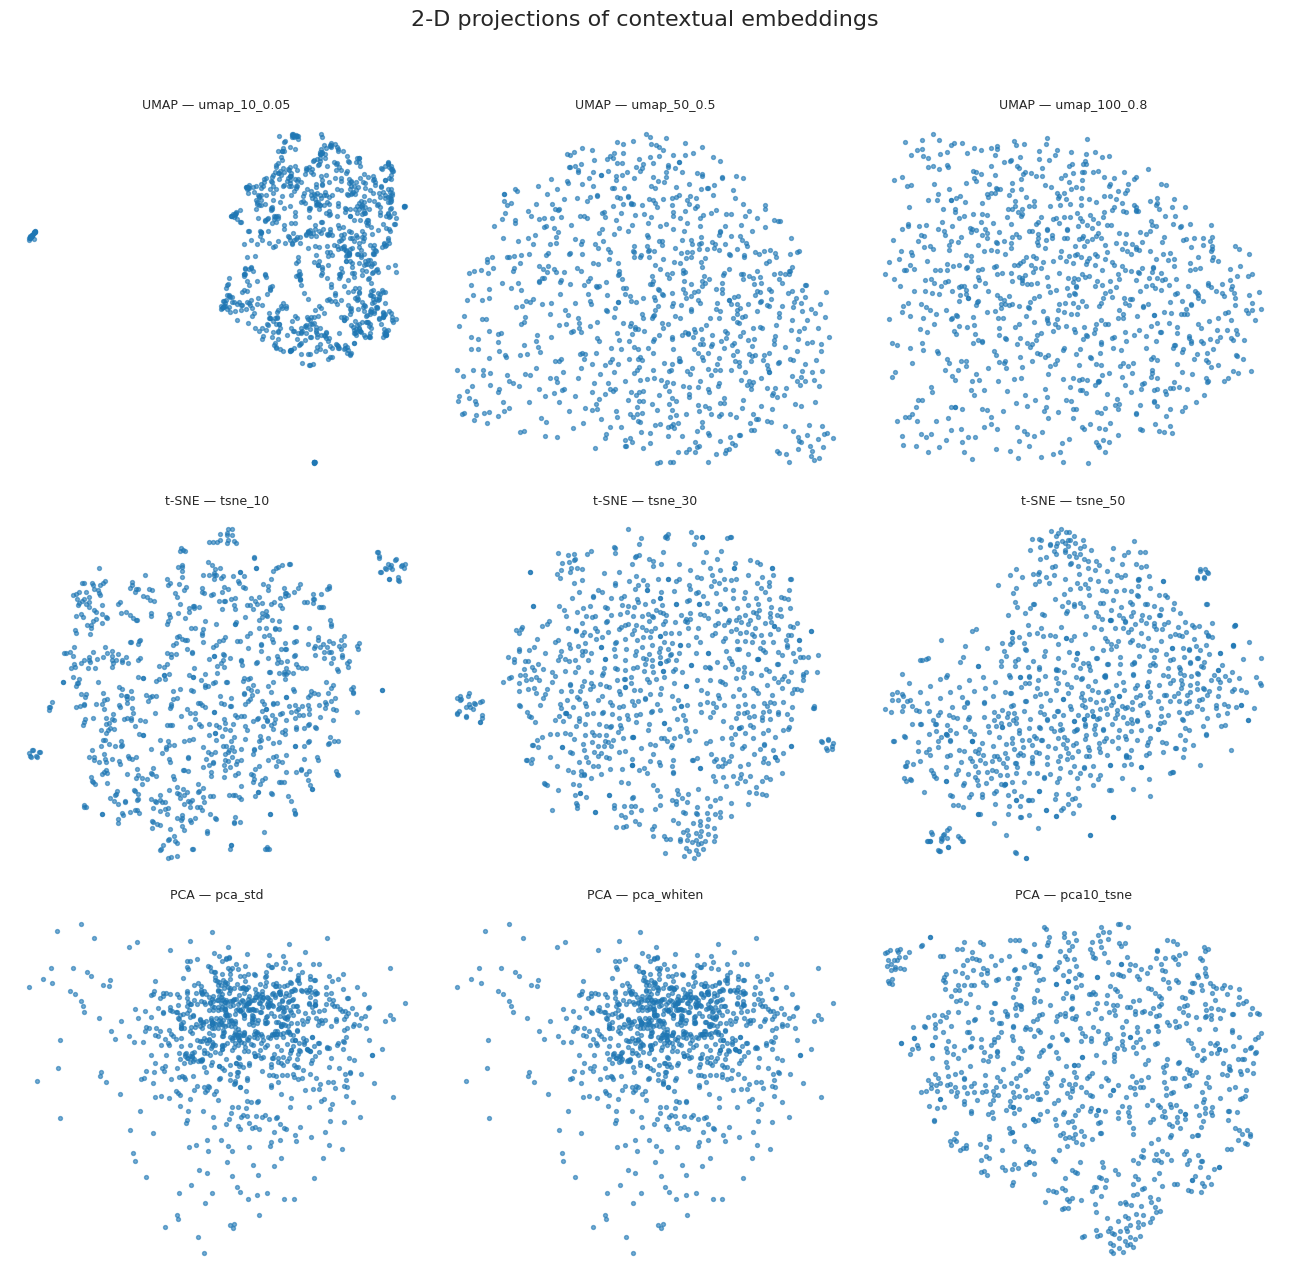

In [162]:
# Choose any embedding column you've built:
emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)

proj_series = compute_projections(emb_array)
fig = plot_projections(proj_series)
fig.show()#%%

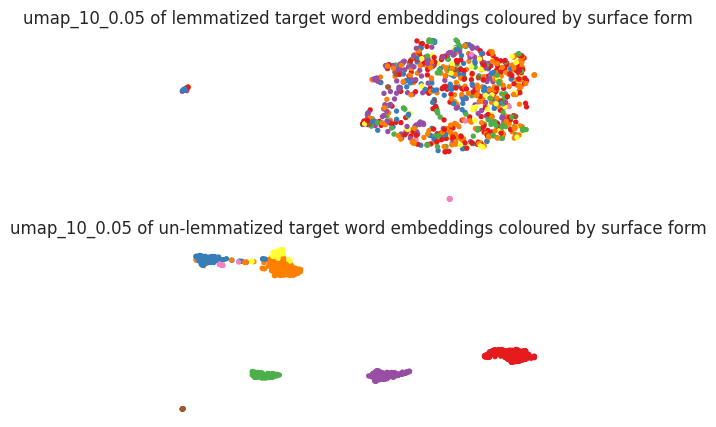

In [170]:
surface = labyrinthus_df["concordance_tokens"].apply(
    lambda toks: next(t for t in toks if t["lemma"].lower() == "labyrinthus")["token_text"].lower()
)

palette = {f: c for f, c in zip(surface.unique(), plt.cm.Set1.colors)}


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 5))

emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"
xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]

ax1.scatter(xs, ys, c=surface.map(palette), s=8)
ax1.set_title(f"{proj_key} of lemmatized target word embeddings coloured by surface form")
ax1.axis("off")

emb_array = np.stack(labyrinthus_df["embed_surface_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"

xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]
ax2.scatter(xs, ys, c=surface.map(palette), s=8)
ax2.set_title(f"{proj_key} of un-lemmatized target word embeddings coloured by surface form")
ax2.axis("off")

plt.show()

In [2]:
labyrinthus_df.head(5)

NameError: name 'labyrinthus_df' is not defined

In [ ]:
surface = labyrinthus_df'["concordance_tokens"].apply(
    lambda toks: next(t for t in toks if t["lemma"].lower() == "labyrinthus")["token_text"].lower()
)

palette = {f: c for f, c in zip(surface.unique(), plt.cm.Set1.colors)}


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5, 5))

emb_array = np.stack(labyrinthus_df["embed_hybrid_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"
xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]

ax1.scatter(xs, ys, c=surface.map(palette), s=8)
ax1.set_title(f"{proj_key} of lemmatized target word embeddings coloured by surface form")
ax1.axis("off")

emb_array = np.stack(labyrinthus_df["embed_surface_allpos"].values)
proj_series = compute_projections(emb_array)

proj_key = "umap_10_0.05"

xs = proj_series.str[proj_key].str["x"]
ys = proj_series.str[proj_key].str["y"]
ax2.scatter(xs, ys, c=surface.map(palette), s=8)
ax2.set_title(f"{proj_key} of un-lemmatized target word embeddings coloured by surface form")
ax2.axis("off")

plt.show()